In [1]:
import pandas as pd
import numpy as np
import string
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
data_path = 'C:/Users/devquinn/OneDrive - Deloitte (O365D)/Desktop/atom-dc-coa/dc-atom-coa/project/data/BS/'
files = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
df = pd.DataFrame()

for letter in files:
    file_name = 'Company'+letter+'.xlsx'
    df_company = pd.read_excel(data_path+file_name, dtype=str, sheet_name='Sheet1', header=0)
    df = pd.concat([df, df_company])

#cut to 3 source/target levels
df = df.drop(['Target Level 4', 'Source Level 4', 'Source Level 5', 'Source Level 6', 'Source Level 7',
              'Source Level 8', 'Source Level 9', 'Source Level 10'], axis=1)
#shuffle
#df = df.sample(frac=1)
df.head(3)

,Division,Industry,Source Account #,Source Level 1,Source Level 2,Source Level 3,Source Account Description,Target Account #,Target Level 1,Target Level 2,Target Level 3,Target Account Description
0,Manufacturing,Misc Apparel and Accessories,02-07218,Liabilities,Current Liabilities,Accounts Payable,Rapid Retail,200101,Liabilities,Current Liabilities,Accounts Payable,Accounts Payable - Trade
1,Manufacturing,Misc Apparel and Accessories,102351,Assets,Current Assets,Accounts Receivable,Sublicense Receivable,101304,Assets,Current Assets,Accounts Receivable,Accounts Receivable - Sublicense Receivable
2,Manufacturing,Misc Apparel and Accessories,02-kbsmt001,Liabilities,Current Liabilities,Accounts Payable,SMT Associates Ltd,200101,Liabilities,Current Liabilities,Accounts Payable,Accounts Payable - Trade


In [12]:
df.dtypes

Division                      object
Industry                      object
Source Account #              object
Source Level 1                object
Source Level 2                object
Source Level 3                object
Source Account Description    object
Target Account #              object
Target Level 1                object
Target Level 2                object
Target Level 3                object
Target Account Description    object
dtype: object

In [13]:
def preprocess_text(text):

    text = str(text)
    text = text.lower().strip()
    text = "".join([char for char in text if char not in string.punctuation+string.digits])
    text = re.sub('\\s+', ' ', text)

    return text

def plot_loss(model_name, losses, n_iters, benchmark_every, learning_rate):
    x = np.arange(0, n_iters, benchmark_every)
    y = losses
    plt.figure()
    plt.plot(x, y)
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    #current_dir = os.getcwd()
    # save_to = os.path.join(current_dir, r'loss_plots')
    # if not os.path.exists(save_to): os.makedirs(save_to)
    # plt.savefig(os.path.join(save_to, f'loss_{model_name}_{learning_rate}.jpg'))
    plt.show()


In [14]:
source_data = df.iloc[:, 3:7].copy()
for col in source_data.columns:
    source_data[col] = source_data[col].apply(preprocess_text)

target_data = df.iloc[:, 8:].copy()
for col in target_data.columns:
    target_data[col] = target_data[col].apply(preprocess_text)

x_train, x_test, y_train, y_test = train_test_split(source_data, target_data, test_size=0.15, shuffle=True, random_state=10)
print(f'Training size: {len(x_train)}  \nTesting size: {len(x_test)}')
x_train.head(3)

Training size: 19116  
Testing size: 3374


,Source Level 1,Source Level 2,Source Level 3,Source Account Description
1866,nan,nan,nan,ircs pchproduction resiting expenses pc ba
5479,nan,nan,nan,accrual medial fee
1222,m mars financial statement v full trial balan,non corporate accounts,balance sheet,legal memo account for fiscal losses credit


## Word Encoding

In [57]:
SOS_token = 0
EOS_token = 1

class Vocabulary:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNKNOWN"}
        self.n_words = 3  # Count SOS, EOS, UNKNOWN

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [97]:
def create_pairs(x_data, y_data):

    x_data = x_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)

    sources, targets = [], []
    
    for i in range(len(x_data)):
        source_level_text, target_level_text = [], []

        for col in x_data:
            s_text = x_data.loc[i, col]
            source_level_text.append(s_text)
        for col in y_data:
            t_text = y_data.loc[i, col]
            target_level_text.append(t_text)

        sources.append(source_level_text)
        targets.append(target_level_text)

    pairs = list((zip(sources, targets)))
    
    return pairs

def create_vocabulary(set1, set2, x_data, y_data):
    
    input_set = Vocabulary(set1)
    output_set = Vocabulary(set2)
    pairs = create_pairs(x_data, y_data)

    for pair in pairs:
        full_source_string = " ".join(pair[0])
        full_target_string = " ".join(pair[1])
        input_set.add_sentence(full_source_string)
        output_set.add_sentence(full_target_string)

    return input_set, output_set, pairs


In [134]:
input_set, output_set, pairs = create_vocabulary('legacy', 'new', x_train, y_train)
pairs[0]

(['nan', 'nan', 'nan', 'ircs pchproduction resiting expenses pc ba'],
 ['nan', 'nan', 'nan', 'eqty clr acct tax'])

In [136]:
def indexes_from_sentence(set, sentence):
    sentence_indexes = []
    for word in sentence.split(' '):
        if word not in set.word2index:
            sentence_indexes.append(2)
        else:
            sentence_indexes.append(set.word2index[word])
            
    return sentence_indexes

def tensor_from_sentence(set, sentence):
    indexes = indexes_from_sentence(set, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensors_from_text_list(text_list, input_set, output_set):
    tensors = []
    for level in text_list:
        print(level)
        tensor = tensor_from_sentence(input_set, level)
        tensors.append(tensor)
        
    return tensors

def tensors_from_pair(pair, input_set, output_set):
    source = pair[0]
    target = pair[1]
    source_target_pairwise_tensors = []

    for i in range(len(source)):
        source_level = source[i]
        target_level = target[i]
        source_level_tensor = tensor_from_sentence(input_set, source_level)
        target_level_tensor = tensor_from_sentence(output_set, target_level)
        source_target_pairwise_tensors.append((source_level_tensor, target_level_tensor))

    return source_target_pairwise_tensors

tensors_from_pair(pairs[0], input_set, output_set)[3]

(tensor([[4],
         [5],
         [6],
         [7],
         [8],
         [9],
         [1]]),
 tensor([[4],
         [5],
         [6],
         [7],
         [1]]))

## Model

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.name = 'Decoder'
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoder(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=100):
        super(AttnDecoder, self).__init__()
        self.name = 'AttnDecoder'
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [185]:
L1_loss, L2_loss, L3_loss, L4_loss = 0, 1, 2, 3
L2_loss += 5
level_losses = [L1_loss, L2_loss, L3_loss, L4_loss]
level_losses[1]

6

## Training

In [193]:
def run_iter(tensors_pair, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=100, teacher_forcing_ratio=0.0):

    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    L1_loss, L2_loss, L3_loss, L4_loss = 0, 0, 0, 0
    level_losses = [L1_loss, L2_loss, L3_loss, L4_loss]
    target_lengths = []

    for i in range(len(tensors_pair)):
        source_level_tensor = tensors_pair[i][0]
        target_level_tensor = tensors_pair[i][1]
        source_level_length = source_level_tensor.size(0)
        target_level_length = target_level_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        #loop through each word of the source level
        for en in range(source_level_length):
            encoder_output, encoder_hidden = encoder(source_level_tensor[en], encoder_hidden)
            encoder_outputs[en] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for de in range(target_level_length):
                if(decoder.name == 'AttnDecoder'):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
                level_losses[i] += criterion(decoder_output, target_level_tensor[de])
                decoder_input = target_level_tensor[de]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for de in range(target_level_length):
                if(decoder.name == 'AttnDecoder'):
                    decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
                else:
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                level_losses[i] += criterion(decoder_output, target_level_tensor[de])
                if decoder_input.item() == EOS_token:
                    break
            
        level_losses[i].backward(retain_graph=True)
        target_lengths.append(target_level_length)

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_target_length = np.sum(target_lengths)
    loss = 0
    for level_loss in level_losses:
        loss += level_loss.item()

    return loss / total_target_length


def train_model(input_set, output_set, encoder, decoder, pairs, n_iters, save_path, model_name, hidden_size, dropout=None, attention=False, benchmark_every=100, save_every=100, learning_rate=0.01,
                tf_ratio=0.0, max_length=100, verbose=False):
    
    if (save_every > n_iters) or (benchmark_every > n_iters):
        raise ValueError('Parameter num_iters must be larger than paramters save_every and benchmark_loss_every')
    if n_iters % benchmark_every != 0:
        raise ValueError('Parameter num_iters must be evenly divisible by parameter benchmark_loss_every')

    if(verbose): print(f'\ntraining model...')
    loss_total = 0  # Reset every benchmark_every
    losses = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #create training pairs randomly from given list of pairs
    training_pairs = [tensors_from_pair(random.choice(pairs), input_set, output_set) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    #run iteration for each training pair
    for i in tqdm(range(1, n_iters + 1)):
        tensors_pair = training_pairs[i - 1]

        loss = run_iter(tensors_pair, encoder, decoder, encoder_optimizer, decoder_optimizer, 
                        criterion, max_length=max_length, teacher_forcing_ratio=tf_ratio)
        
        loss_total += loss
        #record loss
        if i % benchmark_every == 0:
            loss_avg = loss_total / benchmark_every
            losses.append(loss_avg)
            loss_total = 0
        #save model parameters
        if i % save_every == 0:
            torch.save({'en_sd': encoder.state_dict(),
                        'de_sd': decoder.state_dict(),
                        'en_opt': encoder_optimizer,
                        'de_opt': decoder_optimizer,
                        'en_opt_sd': encoder_optimizer.state_dict(),
                        'de_opt_sd': decoder_optimizer.state_dict(),
                        'loss': losses[-1],
                        'input_dict': input_set.__dict__,
                        'output_dict': output_set.__dict__,
                        'hidden_size': hidden_size,
                        'dropout': dropout, 
                        'max_length': max_length,
                        'attention': attention,
                        }, os.path.join(save_path, f'{model_name}_{i}_{losses[-1]:.3f}.hdf5'))

    plot_loss(model_name, losses, n_iters, benchmark_every, learning_rate)


training model...


100%|██████████| 2000/2000 [11:43<00:00,  2.84it/s]


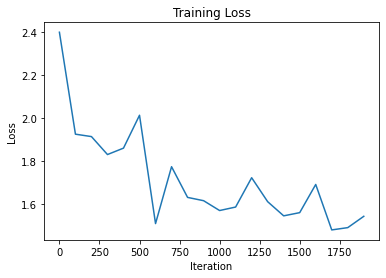

In [194]:
encoder = Encoder(input_set.n_words, 256).to(device)
decoder = Decoder(256, output_set.n_words).to(device)

save_path = os.getcwd()

train_model(input_set, output_set, encoder, decoder, pairs, n_iters=2000, save_path=save_path, model_name='model1',
            hidden_size=256, dropout=None, attention=False, save_every = 2000, benchmark_every=100, verbose=True)